# The Leornian Drill algorithm

- By: [D.J. Ramones](https://github.com/djramones/)
- License: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) for text and graphics; [BSD 3-Clause](https://opensource.org/license/bsd-3-clause/) for code
- Environment: Anaconda 2023.09, Python 3.11 (`anaconda=2023.09=py311_mkl_1`)

This is a description and simple study of the algorithm that powers [Leornian](https://github.com/djramones/leornian)’s “Drill” function, a [spaced repetition](https://en.wikipedia.org/wiki/Spaced_repetition)-inspired method for presenting content, one by one, from a collection.

I make no claim about the novelty or usefulness of this algorithm, and, in fact, during Leornian’s development I came across more-sophisticated, better-researched software implementations of spaced repetition, in the form of [Anki](https://apps.ankiweb.net/) and [SuperMemo](https://en.wikipedia.org/wiki/SuperMemo). For specific objectives such as memorizing information in preparation for exams, I recommend these established products instead of a more casual tool like Leornian.

## Concept and Development

I wanted a method for periodically reviewing a collection of notes in a randomized way, inspired by [Tiago Forte](https://fortelabs.com/)’s idea that adding such an element of randomization when revisiting notes can produce serendipity and creativity, which can be lacking when reviewing in a linear, deterministic order. However, pure randomness (i.e., selection according to a uniform probability distribution) is too chaotic; I thought the system should also tend towards resurfacing notes I haven’t seen for a long time, and this happens to be similar to the established concept of spaced repetition. At the same time, I do not need a highly-tuned and calibrated system like SuperMemo, so I came up with a random selection algorithm that uses a probability distribution heavily biased towards selecting the longest-unseen items. Specifically, in Leornian I use a power function distribution.

Additionally, I discovered that I wanted a way to “promote” certain items such that they will come up more often in the course of revisiting the collection. This is because the notes that I wanted to use this system for is a collection of reminders or “notes to self”, and, depending on various circumstances, I will find that some of the notes are more relevant and important than the others, and that this state varies over time—such that the “promotion”, or prioritization status, should be an attribute I can toggle on and off for individual notes. This added element of interactivity can also nudge the user towards more actively reflecting on the content presented.

To implement the prioritization aspect, I played around with variants of the power function; I had to make the prioritized items appear more often without crowding out the unprioritized items. Eventually, I settled on a simple linear function to achieve this balance. I created the simulations below to check this, and the effects of the algorithm in general.

The two aspects—randomization with bias towards oldest-presented items, and a prioritization attribute—is what differentiates the Leornian Drill from an algorithm such as the [Fisher–Yates shuffle](https://en.wikipedia.org/wiki/Fisher%E2%80%93Yates_shuffle).

## Description and Implementation

The definitive description of Leornian Drill, of course, is in code; a “laboratory” implementation for simulation use is presented later, but here is a description in English:

Given a sequence (ordered collection) of items, where each item has a boolean attribute indicating priority (“promotion”) status, Leornian Drill randomly selects an item, with heavier weights (higher probability of selection) given to items located towards the tail of the sequence *and* items with priority status. Specifically, items not in priority status are assigned a weight computed from the standard power function; items in priority status are assigned a weight computed from a linear function; in both cases the item’s location serves as the function input value. The selected item is then removed from the sequence and then reinserted at the head.

The system can be thought of as a variation on the basic first-in-first-out (FIFO) [queue](https://en.wikipedia.org/wiki/Queue_(abstract_data_type)), where instead of a deterministic FIFO logic, the removal process is stochastic; and where the removed item is inserted back to the queue. For lack of a better term, this system is termed in this notebook as a **requeueing/requeuer system**.

Similarly, the system can also be thought of as a kind of shuffling algorithm.

The Leornian application implementation, in a web app context, is in the [`Drill` Django View class](https://github.com/djramones/leornian/blob/a7d31a43b4171f8ce52f6580b93d4a56fe01d346/notes/views.py#L380) (see the `post()` method handler and `generate_weights()` function), which depends on the [`Collection` data model](https://github.com/djramones/leornian/blob/a7d31a43b4171f8ce52f6580b93d4a56fe01d346/notes/models/collection.py#L6).

Note that there is almost no consideration of efficiency (space or time) in these implementations. There *is* a consideration of queue capacity, in the minimal sense that the Python implementation has been tested to work even with 100,000+ items.

The implementations also minimize the use of non-standard library packages, especially in the web application, to prioritize maintainability and simplicity, and because the performance advantages of e.g. NumPy are not expected to be significant at the small data volumes anticipated for Leornian.

## Setup

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt

# Set RNG seed for reproducibility:
random.seed("leorniandrill", version=2)

## Functions and distributions

Define the functions to be used for generating randomization weights:

In [2]:
def standard_power_func_values(n, p):
    """
    Returns a list of n values from the standard power function
    distribution, which has the domain (0, 1), with parameter p.
    """
    return [p * ((x / n) ** (p - 1)) for x in range(1, n + 1)]


def linear_func_values(n, a, b=0):
    """
    Returns a list of n values from a basic linear function f(x),
    for n values of x from 1/n to 1.
    """
    return [(a * (x / n) + b) for x in range(1, n + 1)]

Visualize the functions:

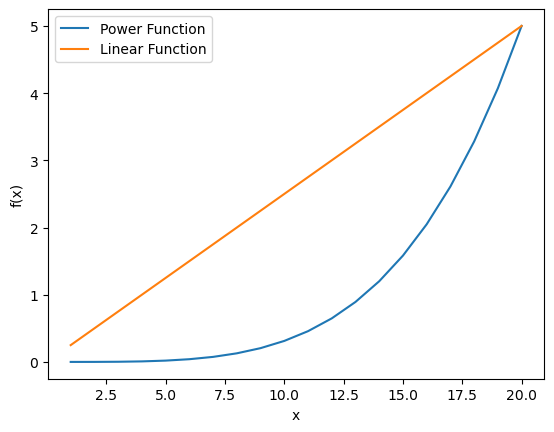

In [3]:
N = 20
P = 5

plt.plot(range(1, N + 1), [y for y in standard_power_func_values(N, P)], label="Power Function")
plt.plot(range(1, N + 1), [y for y in linear_func_values(N, a=P)], label="Linear Function")
plt.xlabel("x"), plt.ylabel("f(x)"), plt.legend()
plt.show()

Define a function for returning a random zero-based index for a list/sequence of size `n`, drawn according to the standard power function distribution. Note that it doesn't matter that the standard power function distribution is in fact continuous, and `random.choices()` is discrete (categorical), as an approximation is sufficient for the algorithm’s purposes.

In [4]:
def draw_index_from_standard_power_dist(n, p):
    domain = list(range(n))
    weights = standard_power_func_values(n, p)
    return random.choices(domain, weights)[0]

Simulate draws using this draw function:

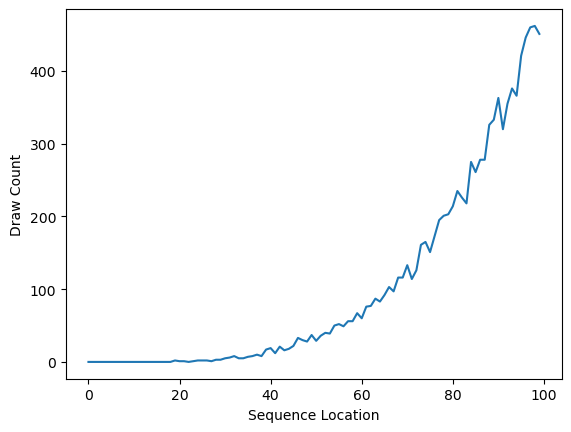

In [5]:
DRAWS = 10_000
N = 100
P = 5

draws_sim = [0 for _ in range(N)]  # initialize draw counts for each item
for _ in range(DRAWS):
    draws_sim[draw_index_from_standard_power_dist(N, P)] += 1  # record the draw
plt.plot(draws_sim)
plt.xlabel("Sequence Location"), plt.ylabel("Draw Count")
plt.show()

## Implementation

Define a class that implements three requeueing systems: the first with basic, deterministic FIFO logic; the second with draws according to the power function distribution; and the third with both power-function-based random draws, and a prioritization aspect using a linear function—the Leornian Drill algorithm.

The class also implements simulation and evaluation logic, and visualizations.

The sequence/collection/queue contents are simply a range of integers (1-based, not 0-based), which is convenient for visualization, because it allows ordering patterns (or the lack thereof) to become quickly apparent when the collection is presented as a bar chart.

For the purposes of the simulation & evaluation logic, the contents can also identified by their initial, zero-based location (index) in the list/queue; admittedly, this can make the code confusing in some parts.

In [6]:
class Requeuer():
    P = 5  # parameter for weight functions

    def __init__(self, queue_len, promoted=[], p=None):
        self.queue_len = queue_len
        self.promoted = promoted  # specifies the promoted items
        if p:
            self.P = p

        # The queue/collection contents are unique integers, generated here
        # sequentially, which makes visualization convenient:
        self.queue = list(range(1, queue_len + 1))

        self.run_num = 0
        self.queue_data = {
            # One list for each queue element:
            "run_nums": [list() for _ in range(queue_len)],
        }

        self.init_queue_computed_data()

    def init_queue_computed_data(self):
        self.queue_computed_data = {
            "draw_counts": [0 for _ in range(self.queue_len)],
            "draw_gaps": [list() for _ in range(self.queue_len)],
        }

    def exec_draw_and_reinsert(self, index):
        self.run_num += 1
        item = self.queue.pop(index)
        self.queue.insert(0, item)
        self.queue_data["run_nums"][item - 1].append(self.run_num)

    def run_simple_requeue(self, runs=1):
        """Deterministic FIFO requeueing."""
        for _ in range(runs):
            self.exec_draw_and_reinsert(self.queue_len - 1)

    def run_standard_power_random_requeue(self, runs=1):
        """Requeueing with power-function-based randomization."""
        for _ in range(runs):
            index = draw_index_from_standard_power_dist(self.queue_len, self.P)
            self.exec_draw_and_reinsert(index)

    def run_leornian_drill_requeue(self, runs=1):
        """
        Requeueing with randomization and promotion components.
        
        If an item is promoted, use a linear function for its draw probability
        weight (for a higher chance of being drawn); otherwise, use the standard
        power function.
        """
        for _ in range(runs):
            domain = list(range(self.queue_len))
            weights = standard_power_func_values(self.queue_len, self.P)
            for item in self.promoted:
                # Look up item's current location:
                index = self.queue.index(item)
                # Assign new weight based on linear function:
                weights[index] = self.P * ((index + 1) / self.queue_len)
            draw_index = random.choices(domain, weights)[0]
            self.exec_draw_and_reinsert(draw_index)

    def plot_queue(self):
        fig, ax = plt.subplots()
        ax.bar(range(1, self.queue_len + 1), self.queue, color="black")
        ax.set(xlabel="Sequence Location", ylabel="Item")
        plt.show()

    def compute_queue_data(self):
        self.init_queue_computed_data()
        for index in range(self.queue_len):
            self.queue_computed_data["draw_counts"][index] = len(
                self.queue_data["run_nums"][index]
            )
            self.queue_computed_data["draw_gaps"][index] = np.diff(
                self.queue_data["run_nums"][index]
            )

    def plot_draw_gaps(self, plot_size=(14, 10)):
        self.compute_queue_data()

        fig, ax = plt.subplots(figsize=plot_size)
        ax.boxplot(self.queue_computed_data["draw_gaps"])
        ax.set(xlabel="Item", ylabel="Draw Gaps")
        plt.show()

## FIFO (deterministic) requeueing

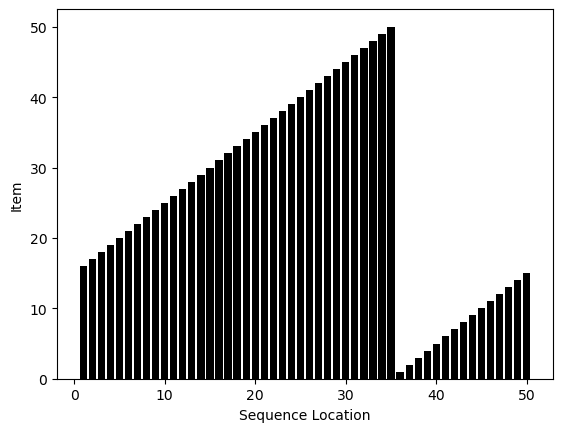

In [7]:
requeuer = Requeuer(queue_len=50)
requeuer.run_simple_requeue(runs=35)
requeuer.plot_queue()

After 35 draws, the basic FIFO requeuer’s collection remains nicely ordered, as expected.

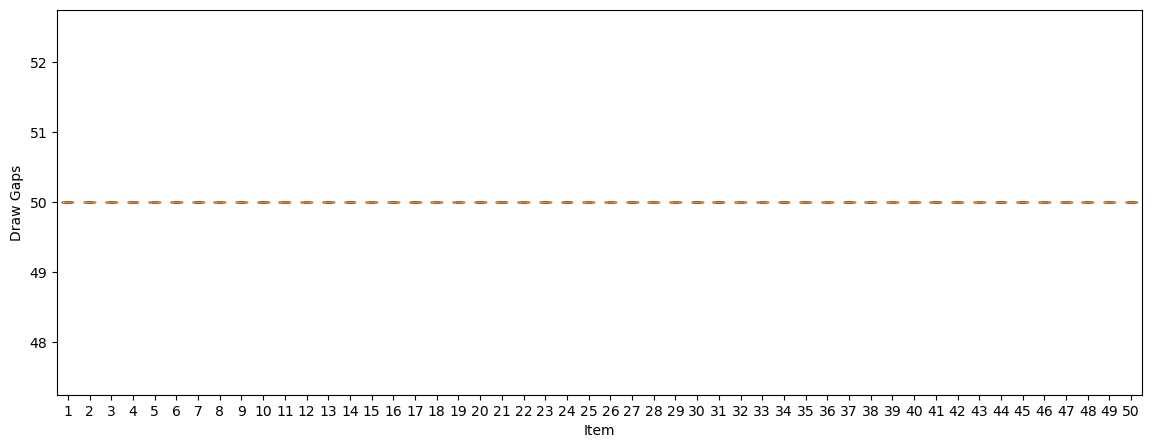

In [8]:
requeuer.run_simple_requeue(500)
requeuer.plot_draw_gaps(plot_size=(14, 5))

Of course, even with many more runs, there is zero variance in the system’s behavior. There are fifty items in the sequence/collection, and each one is always drawn again after exactly fifty runs.

## Requeueing with randomization

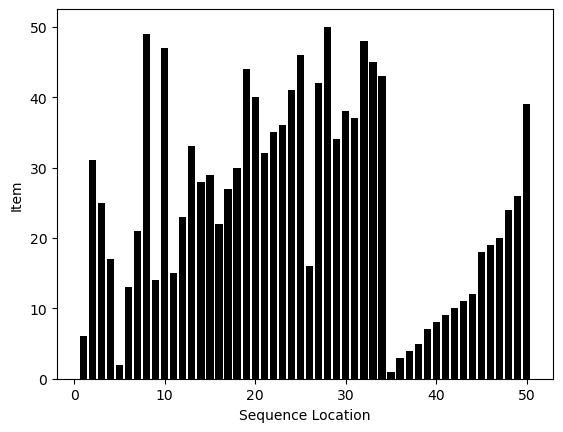

In [9]:
requeuer = Requeuer(queue_len=50)
requeuer.run_standard_power_random_requeue(runs=35)
requeuer.plot_queue()

Even after just 35 runs, fewer than the collection’s item count, the contents already show chaos. The sequence still shows a generally increasing slope shape, reflecting the initial order of items, especially among the items to the right, the ones not yet drawn at least once.

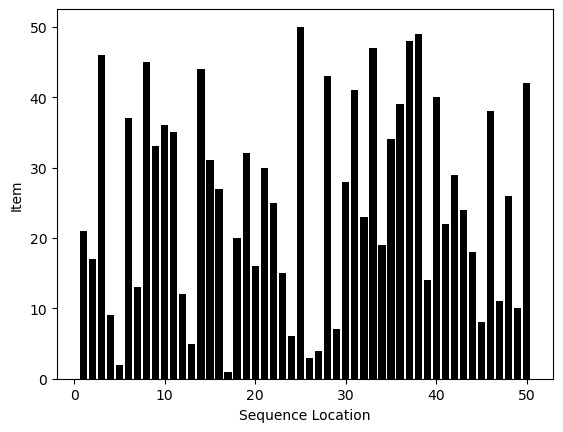

In [10]:
requeuer.run_standard_power_random_requeue(runs=5_000)
requeuer.plot_queue()

After many more runs, the sequence no longer exhibits a clear order, demonstrating the effects of the stochastic (randomized) selection in the long run.

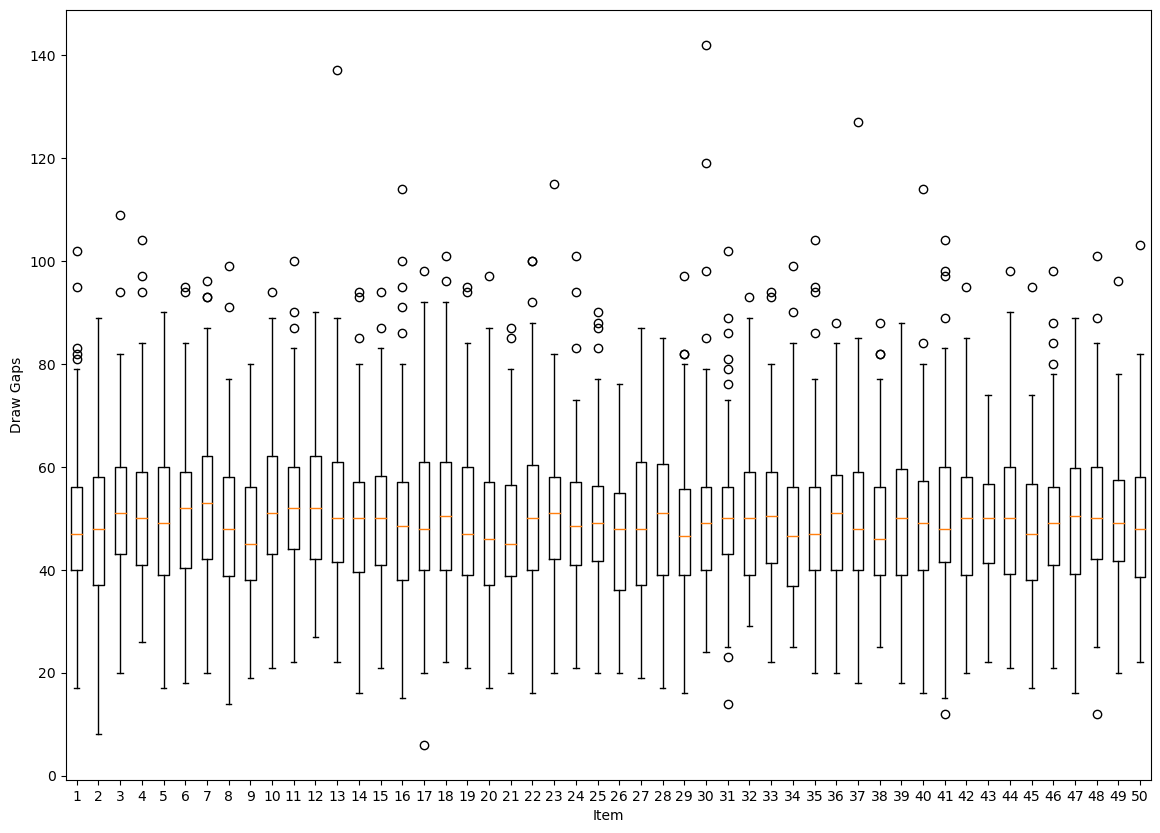

In [11]:
requeuer.plot_draw_gaps()

In the long run, all the items get their fair chance of being drawn, and this box plot of draw gaps (the draw gap is the number of runs/draws since the last time the same item was drawn) shows that now there is a nice variance (spread) to the intervals between selections. The median still hovers around 50, showing that on average, each item in the 50-item collection is drawn again after an equal number of runs, but the actual gap seen in the simulation varies from as low as ~10 to as large as ~140.

## Requeueing with randomization and promotion (Leornian Drill)

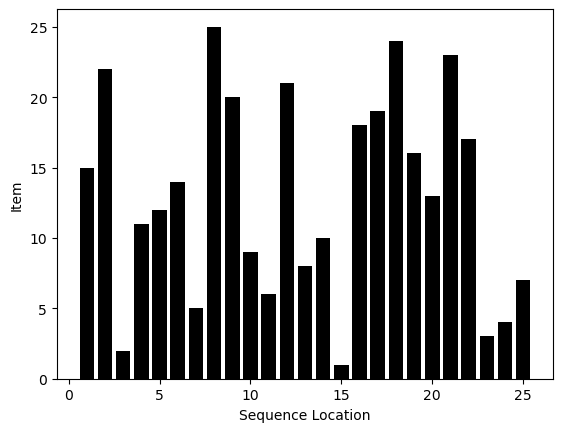

In [12]:
requeuer = Requeuer(queue_len=25, promoted=[3, 4, 5])
requeuer.run_leornian_drill_requeue(runs=5_000)
requeuer.plot_queue()

In the long run, the collection in the Leornian Drill system also shows no clear ordering.

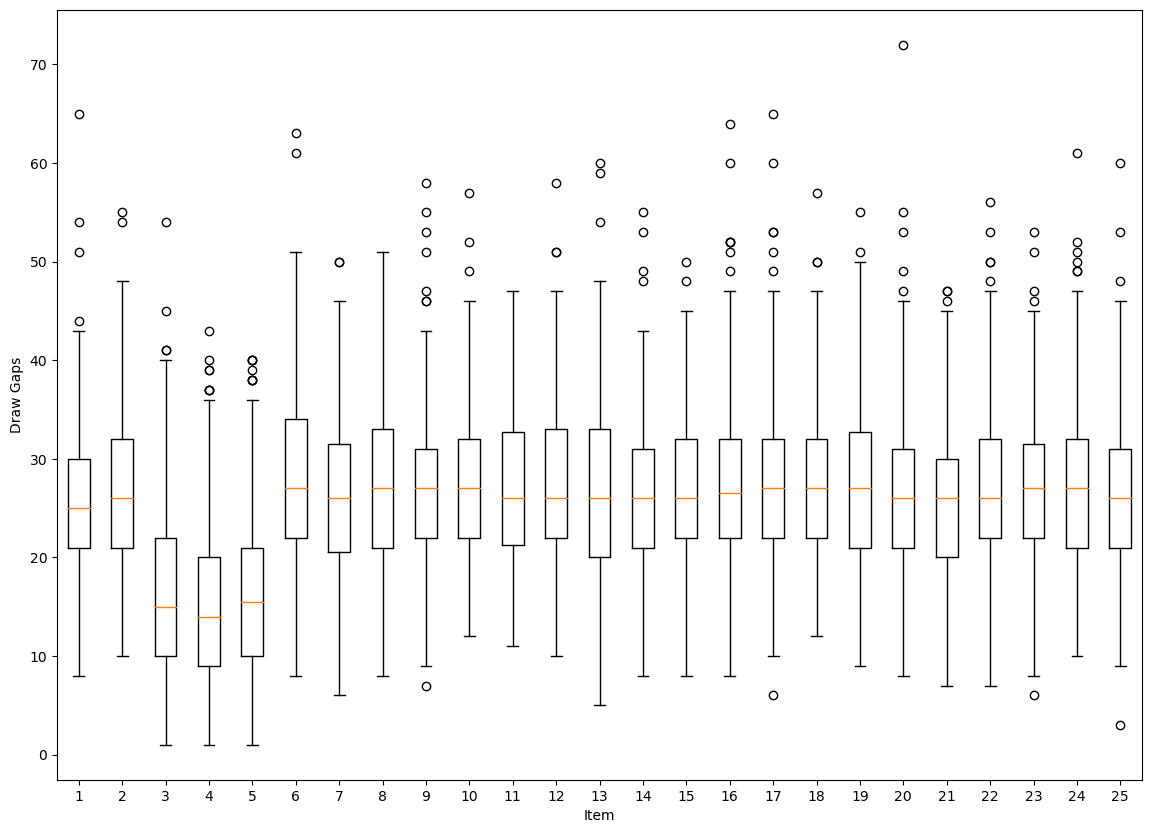

In [13]:
requeuer.plot_draw_gaps()

The draw gaps box plot shows that the promoted items (IDs 3, 4, and 5) are being drawn more often, as intended. The box plot shows just how strong the effect is of using a different (the linear) probability distribution for the prioritized items.

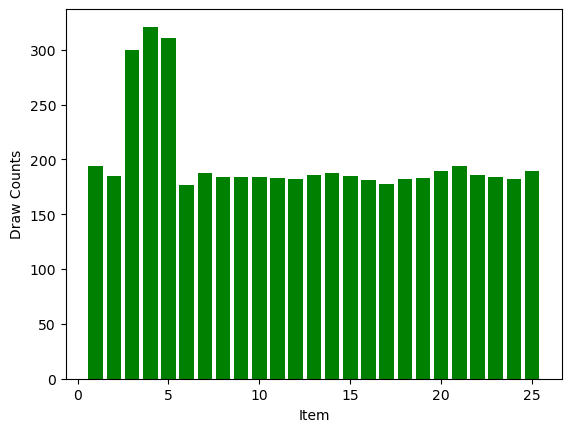

In [14]:
fig, ax = plt.subplots()
ax.bar(range(1, requeuer.queue_len + 1), requeuer.queue_computed_data["draw_counts"], color="g")
ax.set(xlabel="Item", ylabel="Draw Counts")
plt.show()

Here is the actual draw counts of the items.

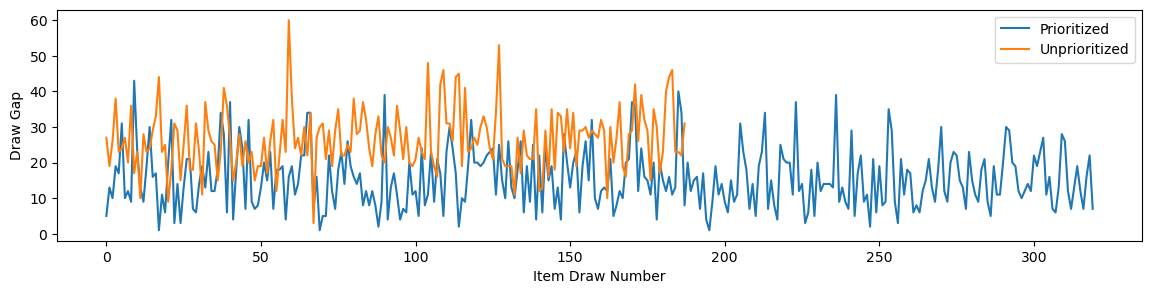

In [15]:
fig, ax = plt.subplots(figsize=(14, 3))
ax.plot(requeuer.queue_computed_data["draw_gaps"][3], label="Prioritized")
ax.plot(requeuer.queue_computed_data["draw_gaps"][24], label="Unprioritized")
ax.set(xlabel="Item Draw Number", ylabel="Draw Gap"), ax.legend()
plt.show()

In this plot, the generally lower draw gaps of the prioritized item provides another view of how more frequently the item is drawn compared to the unprioritized one. The line is also longer, again because it is drawn more times over the duration of the simulation.

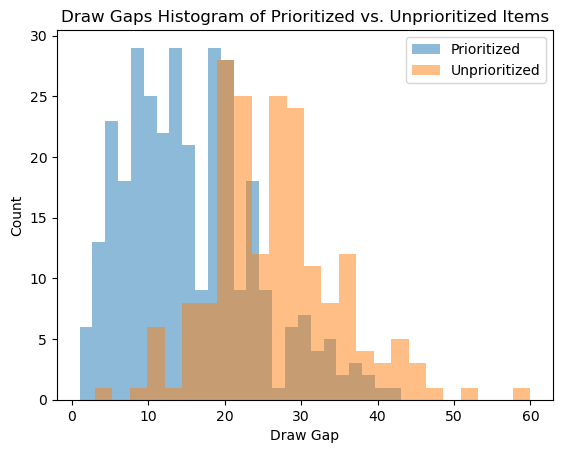

In [16]:
fig, ax = plt.subplots()
ax.hist(requeuer.queue_computed_data["draw_gaps"][3], bins=25, alpha=0.5, label="Prioritized")
ax.hist(requeuer.queue_computed_data["draw_gaps"][24], bins=25, alpha=0.5, label="Unprioritized")
ax.set(title="Draw Gaps Histogram of Prioritized vs. Unprioritized Items", xlabel="Draw Gap", ylabel="Count")
ax.legend()
plt.show()

This histogram provides yet another depiction of how more frequently prioritized items are drawn.